In [1]:
import sys
sys.path.append('../')

import os
import gc
import torch
import psutil
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models, set_image_backend

import data_utils
import train_utils
import model_utils

%reload_ext autoreload
%autoreload 2

set_image_backend('accimage')

## Load Data

In [2]:
pickle_file = '/n/data_labeled_histopathology_images/COAD/train.pkl'
with open(pickle_file, 'rb') as f: 
    train_embeddings, train_labels, train_jpgs_to_slide = pickle.load(f)
    
pickle_file = '/n/data_labeled_histopathology_images/COAD/val.pkl'
with open(pickle_file, 'rb') as f: 
    val_embeddings, val_labels, val_jpgs_to_slide = pickle.load(f)

## Global Vars

In [3]:
input_size = 2048
hidden_size = 2048
output_size = 1
criterion = nn.BCELoss(reduction='none')

## Baseline

In [4]:
state_dict_file = '/n/tcga_models/resnet18_WGD_10x.pt'
resnet = models.resnet18(pretrained=False)
resnet.fc = nn.Linear(input_size, output_size)
saved_state = torch.load(state_dict_file, map_location=lambda storage, loc:storage)
resnet.load_state_dict(saved_state)
for p in resnet.parameters():
    p.requires_grad = False

In [5]:
resnet_fc = resnet.fc
n_samples = val_jpgs_to_slide.max() + 1
probs_vec = torch.zeros((n_samples, 1)).cuda()
labels_vec = torch.zeros_like(probs_vec).cuda()
val_embeddings = val_embeddings.cuda()
resnet_fc.cuda()

Linear(in_features=2048, out_features=1, bias=True)

In [6]:
resnet_fc.eval()
for idx in range(n_samples):
    with torch.no_grad():
        slide = val_embeddings[val_jpgs_to_slide==idx]
        labels_vec[idx] = val_labels[val_jpgs_to_slide==idx].unique().float().cuda()
        probs_vec[idx] = torch.mean((torch.sigmoid(resnet_fc(slide)) > 0.5).float()) # mean pooling the tile-level predicted labels

In [7]:
loss = criterion(probs_vec, labels_vec) # input, target
fpr, tpr, thresholds = metrics.roc_curve(labels_vec.detach().cpu().numpy(), probs_vec.detach().cpu().numpy()) # y_true, y_score
roc_auc = metrics.auc(fpr, tpr)
print(torch.mean(loss), torch.median(loss), roc_auc)

tensor(0.6194, device='cuda:0') tensor(0.4929, device='cuda:0') 0.7240338164251208


## Attention

In [221]:
state_dict_file = '/n/tcga_models/COAD_attention_model_reworked_5_8_acc.pt'
net = model_utils.Attention(input_size, hidden_size, output_size)
saved_state = torch.load(state_dict_file, map_location=lambda storage, loc:storage)
net.load_state_dict(saved_state)
for p in net.parameters():
    p.requires_grad = False
net.cuda()

Attention(
  (V): Linear(in_features=2048, out_features=2048, bias=True)
  (w): Linear(in_features=2048, out_features=1, bias=True)
  (sigm): Sigmoid()
  (tanh): Tanh()
  (sm): Softmax()
  (linear_layer): Linear(in_features=2048, out_features=1, bias=True)
)

In [222]:
net.eval()
with torch.no_grad():
    for idx in range(n_samples):
        slide = val_embeddings[val_jpgs_to_slide==idx]
        labels_vec[idx] = val_labels[val_jpgs_to_slide==idx].unique().float().cuda()
        probs_vec[idx] = torch.mean((torch.sigmoid(net(slide)) > 0.5).float()) # mean pooling the tile-level predicted labels

In [223]:
loss = criterion(probs_vec, labels_vec) # input, target
fpr, tpr, thresholds = metrics.roc_curve(labels_vec.detach().cpu().numpy(), probs_vec.detach().cpu().numpy()) # y_true, y_score
roc_auc = metrics.auc(fpr, tpr)
print(torch.mean(loss), torch.median(loss), roc_auc)

tensor(7.0762, device='cuda:0') tensor(-0., device='cuda:0') 0.7445652173913043


## Rationales

In [11]:
def pool_fn(x):
    #v,a = torch.max(x,0)
    v = torch.mean(x,0)
    return v

In [12]:
state_dict_file = '/n/tcga_models/COAD_rationale_model_gen_5_9_acc.pt'
output_size = 2
gen = model_utils.Generator(input_size, hidden_size, output_size, dropout=0.5)
saved_state = torch.load(state_dict_file, map_location=lambda storage, loc:storage)
gen.load_state_dict(saved_state)
for p in gen.parameters():
    p.requires_grad = False
gen.cuda()

Generator(
  (d): Dropout(p=0.5)
  (m): ReLU()
  (linear1): Linear(in_features=2048, out_features=2048, bias=True)
  (linear2): Linear(in_features=2048, out_features=2, bias=True)
)

In [13]:
state_dict_file = '/n/tcga_models/COAD_rationale_model_enc_5_9_acc.pt'
output_size = 1
enc = model_utils.Encoder(input_size, hidden_size, output_size, pool_fn, dropout=0.5)
saved_state = torch.load(state_dict_file, map_location=lambda storage, loc:storage)
enc.load_state_dict(saved_state)
for p in enc.parameters():
    p.requires_grad = False
enc.cuda()

Encoder(
  (d): Dropout(p=0.5)
  (m): ReLU()
  (linear1): Linear(in_features=2048, out_features=2048, bias=True)
  (linear2): Linear(in_features=2048, out_features=1, bias=True)
)

In [14]:
gen.eval()
enc.eval()
with torch.no_grad():
    for idx in range(n_samples):
        slide = val_embeddings[val_jpgs_to_slide==idx]
        labels_vec[idx] = val_labels[val_jpgs_to_slide==idx].unique().float().cuda()

        preds = gen(slide)
        sample = torch.argmax(preds, dim=1).float()
        rationale = slide * sample.unsqueeze(1)

        logits = enc(rationale)
        probs_vec[idx] = torch.mean((torch.sigmoid(logits) > 0.5).float()) # mean pooling the tile-level predicted labels

In [15]:
loss = criterion(probs_vec, labels_vec) # input, target
fpr, tpr, thresholds = metrics.roc_curve(labels_vec.detach().cpu().numpy(), probs_vec.detach().cpu().numpy()) # y_true, y_score
roc_auc = metrics.auc(fpr, tpr)
print(torch.mean(loss), torch.median(loss), roc_auc)

tensor(7.7502, device='cuda:0') tensor(-0., device='cuda:0') 0.7288647342995169


## Images

In [224]:
# get idxs of correct predictions
np.argwhere(probs_vec.detach().cpu().numpy() == labels_vec.detach().cpu().numpy())[:,0]

array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 11, 13, 15, 16, 17, 18, 19, 20,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 36, 38, 40, 44, 45,
       46, 47, 51, 52, 53, 54, 55, 57, 58, 59, 60, 62, 63, 64, 65, 68, 69,
       70, 71, 72, 74, 75, 76, 77, 78, 79, 81])

In [225]:
# get idx of correct WGD prediction
idx = 17
labels_vec[idx], probs_vec[idx]

(tensor([1.], device='cuda:0'), tensor([1.], device='cuda:0'))

In [226]:
# forward pass of attention model
slide = val_embeddings[val_jpgs_to_slide==idx]
logits, attn = net.forward(slide, return_attention=True)

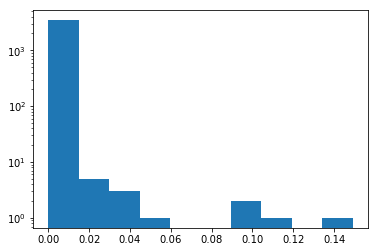

In [227]:
# histograph of attention weights
plt.hist(attn.detach().cpu().numpy())
plt.semilogy()
plt.show()

In [228]:
# sort attention weights ascending
torch.argsort(attn, dim=0)

tensor([[  65],
        [2011],
        [  63],
        ...,
        [2227],
        [1965],
        [ 872]], device='cuda:0')

In [238]:
# tile with highest attention weight
impt_tile = torch.argmax(attn).item()

In [231]:
# load validation annotations
pickle_file = '/n/tcga_models/resnet18_WGD_10x_sa.pkl'
_, sa_vals = data_utils.load_COAD_train_val_sa_pickle(pickle_file=pickle_file,
                                                              return_all_cancers=False,
                                                              split_in_two=False)

In [232]:
# load validation set
root_dir = data_utils.root_dir_all
val_cancers = ['COAD']
transform_val = train_utils.transform_validation
magnification = '10.0'
val_sets = []
for j in range(len(val_cancers)):
    val_set = data_utils.TCGADataset_tiles(sa_vals, root_dir + val_cancers[j] + '/', transform=transform_val, 
                                           magnification=magnification, return_jpg_to_sample=True)
    val_sets.append(val_set)

In [233]:
# get num tiles by slide
counts = Counter(val_sets[0].jpg_to_sample)

In [237]:
# get tile start idx
tile_idx = np.sum(counts[i] for i in range(idx))

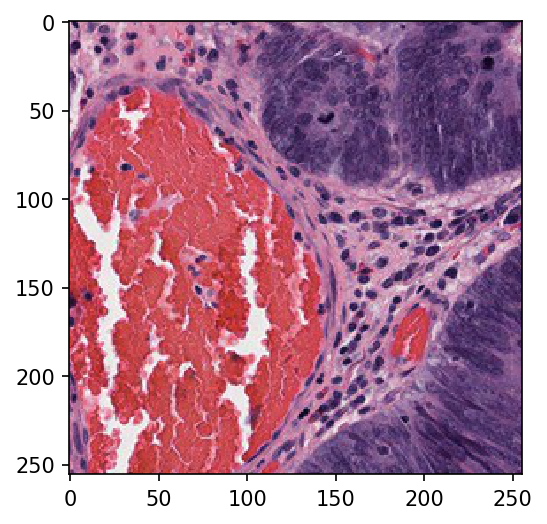

In [235]:
# example of neg tile
image = data_utils.pil_loader(val_sets[0].all_jpegs[tile_idx+2289])
fig,ax = plt.subplots(1,1)
ax.imshow(image)
fig.set_dpi(150)
fname = 'WGD_pos_slide_neg_tile.png'
plt.imsave(fname, image)

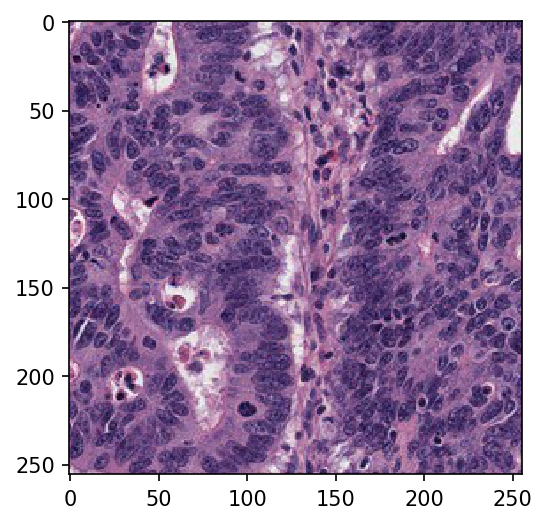

In [236]:
# example of pos tile
image = data_utils.pil_loader(val_sets[0].all_jpegs[tile_idx-impt_tile+2227])
fig,ax = plt.subplots(1,1)
ax.imshow(image)
fig.set_dpi(150)
fname = 'WGD_pos_slide_pos_tile.png'
plt.imsave(fname, image)